#ML4Net - Lab 2

## Team members

Javi (266933) | Marta (267436) | Arnau (216530)

## Description

In this lab, you will implement an ML model that detects congestion in Wi-Fi networks. In particular, you will desing and implement a supervised learning model (e.g., linear regression, multi-layer perceptron, neural network), which you will train using a dataset that was generated using the ns-3 simulator.

Each row in the dataset is organized as (x1, x2, ..., x26, y1, y2, ..., y26, s, r, l), where:

* `x1, x2..., x26, y1, y2, ..., y26` represent the histogram of the Inter-Frame Space (IFS) values for M frames that accessed the medium in a 60 seconds observation sample.
  * `x26` represents the maximum IFS duration (in ms) in the considered M frames whereas `x1` is `x26`/26
  * The remaining `xi` values are buckets at uniform spacing between `x1` and `x26`.
  * For i>1, the values of `yi` represent the IFS histogram count (in percentage) for a corresponding bucket interval between `xi`-1 and `xi`.
  * In the case of `y1`, the bucket interval is between 0 and `x1`
* `s` is the average IFS duration (in ms)
* `r` is the percentage of frame collisions
* `l` is the label, where 1 indicates that the network is saturated, and 0, that it is not

Original dataset: https://ieee-dataport.org/documents/dataset-identification-saturated-and-unsaturated-wi-fi-networks

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   Submission deadline: 25 May 2025 (EoB).

## Setting up the environment

1. Connect your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Download the dataset

In [2]:
# !wget https://github.com/fwilhelmi/fwilhelmi.github.io/raw/refs/heads/master/files/dataset_Lab2.zip

3. Define the main path of the code

In [3]:
mypath="drive/Shareddrives/AAX/Lab2"

4. Extract the source code to the destination folder

In [4]:
# mkdir $mypath; cp dataset_Lab2.zip $mypath; cd $mypath; unzip dataset_Lab2.zip

In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


## Visualizing the data




We print the data and plot the histogram of the IFS to visualize the distribution of the dataset.

       0       1       2       3       4       5       6       7       8   \
0  0.0065  0.0130  0.0195  0.0260  0.0325  0.0390  0.0455  0.0520  0.0585   
1  0.0263  0.0526  0.0789  0.1052  0.1316  0.1579  0.1842  0.2105  0.2368   
2  0.0176  0.0352  0.0528  0.0704  0.0881  0.1057  0.1233  0.1409  0.1585   
3  0.0222  0.0444  0.0666  0.0888  0.1110  0.1332  0.1554  0.1776  0.1998   
4  0.0189  0.0379  0.0568  0.0758  0.0947  0.1137  0.1326  0.1516  0.1705   

       9   ...      45      46      47      48      49      50      51  \
0  0.0650  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   
1  0.2631  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   
2  0.1761  ...  0.0316  0.0368  0.0312  0.0312  0.0316  0.0299  0.0304   
3  0.2220  ...  0.0316  0.0307  0.0312  0.0000  0.0360  0.0364  0.0304   
4  0.1895  ...  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304   

       52      53  54  
0  0.0604  0.9960   1  
1  0.0604  0.9960   1  
2  0.0604  0.9957   

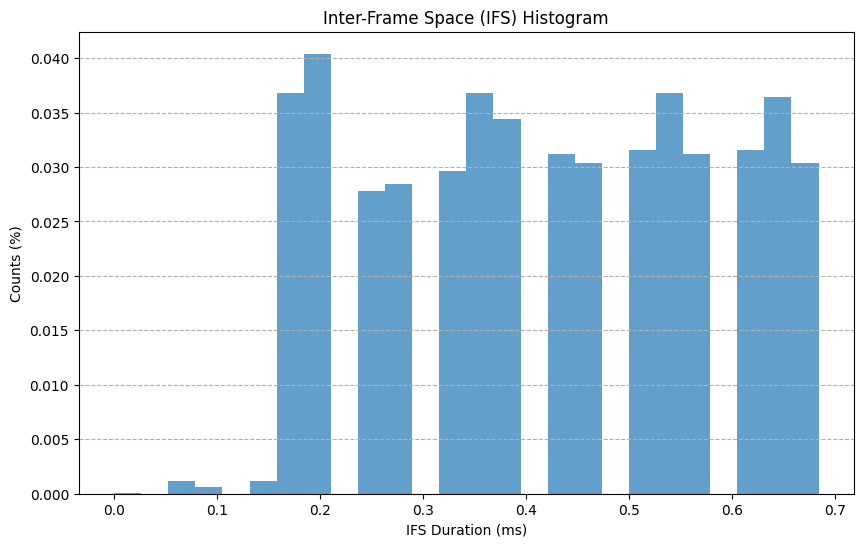

In [6]:
def plot_ifs_histogram(data_row):
    """
    Plots the Inter-Frame Space (IFS) histogram from a single row of the dataset.

    Args:
        data_row (list or numpy.ndarray): A list or array representing a single row
                                          in the format (x1, ..., x26, y1, ..., y26, s, r, l).
    """

    # Get IFS values and the corresponding counts
    x_values = np.array(data_row[:26])
    y_counts = np.array(data_row[26:52])

    # Calculate the bin edges based on x_values
    bin_edges = [0] + list(x_values)

    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], y_counts, width=np.diff(bin_edges)[0], align='edge', alpha=0.7)

    # Add labels and title
    plt.xlabel("IFS Duration (ms)")
    plt.ylabel("Counts (%)")
    plt.title("Inter-Frame Space (IFS) Histogram")
    plt.grid(axis='y', linestyle='--')

    # Show the plot
    plt.show()

# Example usage

# -> Read the data file
file_name = mypath + '/train_data.csv'
train_data_df = pd.read_csv(file_name, header=None)
print(train_data_df.head())

# -> Get a sample from the dataset and plot it
row_index = 1
sample_data = train_data_df.iloc[row_index].values
plot_ifs_histogram(sample_data)

The IFS duration tends to be longer than 0.2 ms, as there is almost no data with lower duration.

## EXERCISES

### **Exercise 1:**
**Define an approach for training and validating the model you are going to train with the proposed data. Then, perform the split accordingly.**

We have decided to use StratifiedkFold to create 5 splits of training and testing data. Then, we use the train subset of those 5 splits in a single model independently and evaluate the individual and the average accuracy using the test subsets. We do this for 4 models, which are:
- Logistic Regression
- Decision Tree
- Random Forest
- Multilayer Perceptron

In [7]:


# Load dataset
file_name = mypath + '/train_data.csv'
df = pd.read_csv(file_name, header=None)

# Separate features and label
X = df.iloc[:, :54].values  # x1-x26, y1-y26, s, r
y = df.iloc[:, 54].values   # label (if network is saturated)

#### Functions to return the object of the model ####
def get_logistic_regression():
    return LogisticRegression(max_iter=1000, random_state=42)

def get_decision_tree():
    return DecisionTreeClassifier(random_state=42)

def get_random_forest():
    return RandomForestClassifier(n_estimators=100, random_state=42)

def get_mlp():
    return MLPClassifier(
        hidden_layer_sizes=(64, 32),  # two layers
        activation='relu',
        solver='adam',
        max_iter=300,
        random_state=42
    )

#####################################################


#### Function for the training and evaluation of each split of the kfold ####
models = []
def train_with_kfold(models, get_model_func, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    all_preds, all_true, accuracies = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n Fold {fold + 1}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Standardize data
        #scaler = StandardScaler()
        #X_train_scaled = scaler.fit_transform(X_train)
        #X_val_scaled = scaler.transform(X_val)

        # Train model
        model = get_model_func()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        models.append(model)

        # Metrics
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
        all_preds.extend(y_pred)
        all_true.extend(y_val)

        print(f" Accuracy: {acc:.4f}")

    print("\n Average Accuracy:", np.mean(accuracies))
    print("\n Classification Report:")
    print(classification_report(all_true, all_preds))
    print(" Confusion Matrix:")
    print(confusion_matrix(all_true, all_preds))

#############################################################################

# Train Logistic Regression
print("Logistic Regression\n")
train_with_kfold(models,get_logistic_regression, X, y)
print("---------------------------------------------------\n")

# Train Decision Tree
print("Decision tree\n")
train_with_kfold(models,get_decision_tree, X, y)
print("---------------------------------------------------\n")

# Train Random Forest
print("Random Forest\n")
train_with_kfold(models,get_random_forest, X, y)
print("---------------------------------------------------\n")

# Train Feedforward Neural Network (MLP)
print("MLP\n")
train_with_kfold(models,get_mlp, X, y)
print("---------------------------------------------------\n")



Logistic Regression


 Fold 1
 Accuracy: 0.9792

 Fold 2
 Accuracy: 0.9755

 Fold 3
 Accuracy: 0.9772

 Fold 4
 Accuracy: 0.9738

 Fold 5
 Accuracy: 0.9722

 Average Accuracy: 0.9756

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10001
           1       0.99      0.96      0.98      9999

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

 Confusion Matrix:
[[9875  126]
 [ 362 9637]]
---------------------------------------------------

Decision tree


 Fold 1
 Accuracy: 0.9995

 Fold 2
 Accuracy: 0.9995

 Fold 3
 Accuracy: 0.9992

 Fold 4
 Accuracy: 0.9985

 Fold 5
 Accuracy: 0.9985

 Average Accuracy: 0.9990500000000001

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10001
           1       1.00      1.00      1.00

All the models we have tried have an accuracy of at least 97%, so the result is always almost 100% accuracy. Given this, we could choose any of these models to train the data.

### **Exercise 2:**

**Define your ML model, so that it can be called for training and test. Examples of approaches that you could use (but not limited to):**

*   **Logistic Regression**
*   **K-Nearest Neighbors (KNN)**
*   **Decision Trees or Random Forests**
*   **Convolutional Neural Network (CNN)**

We could use any of the models tried previously, so we will implement a Decision Tree because it is the one that has performed the best, even if the difference between them is small.

### **Exercise 3:**

**Define the hyperparameters that you will use to train the model.**

We have used the default hyperparameters except for the random_state from the DecisionTreeClassifier object from scikit-learn:
- criterion: gini
- spplitt: best
- max_depth: none
- min_samples_split: 2
- min_sample_leaf: 1
- min_weight_fraction_leaf: 0.0
- max_features: none
- random_state: 42
- max_leaf_nodes: none
- min_impurity_decrease: 0.0
- class_weight: none
- ccp_alpha: 0.0
- monotonic_cst: none

### **Exercise 4:**
**Train the model and show the procedure (e.g., evolution of the training/validation loss).**

Now, we are going to use the entire dataframe to create a single train, test, and val split.

We first try to validate the default Decision Tree Classifier we have tried before.

In [8]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_train, y_val, y_train = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:

# Step 1: Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Step 2: Predict on val set
y_pred = dt_model.predict(X_val)

# Step 3: Validate the model
print(" Accuracy:", accuracy_score(y_val, y_pred))
print("\n Classification Report:")
print(classification_report(y_val, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

 Accuracy: 0.998375

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4027
           1       1.00      1.00      1.00      3973

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


 Confusion Matrix:
[[4022    5]
 [   8 3965]]


After training the model for the first time, we evaluate it using the val split. Next, we can repeat this step as many times as we want while we figure out the best parameters for this model.

We use scikit-learn's built-in function validation_curve to check how the model's performance changes as a specific hyperparameter is adjusted (e.g. min_samples_leaf). This helps to determine the best value for the hyperparameter.

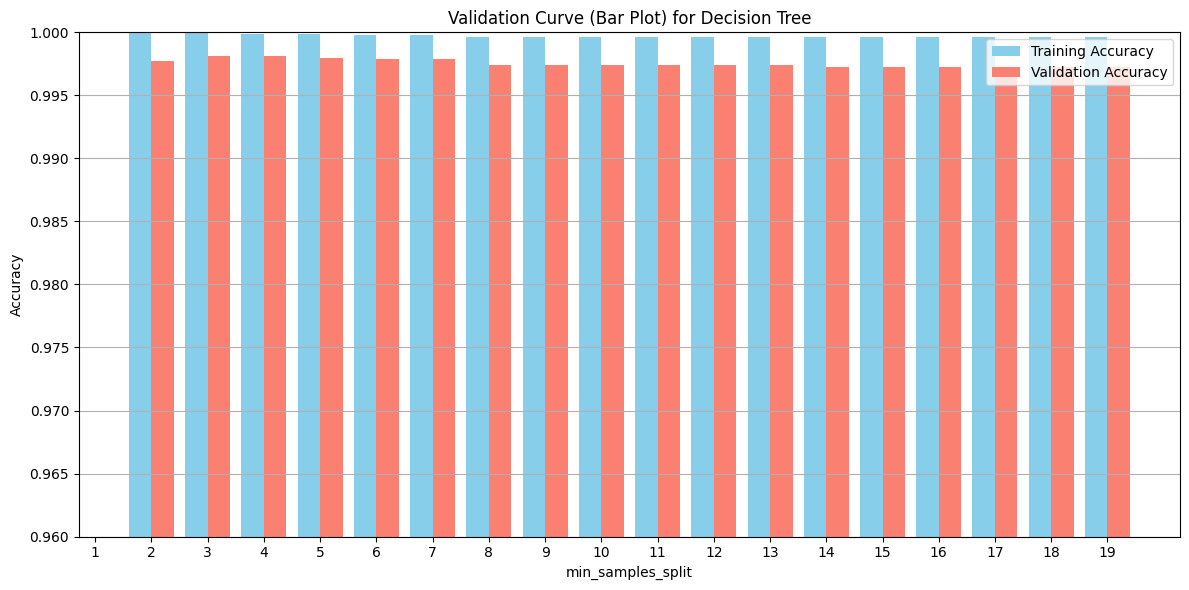

In [10]:
# Define the range of the hyperparameter
param_range = np.arange(1, 20)

# Compute the training and validation scores
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name="min_samples_split",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)

# Average the scores across folds
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Set width of bars
bar_width = 0.4
x = np.arange(len(param_range))

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, train_mean, width=bar_width, label="Training Accuracy", color="skyblue")
plt.bar(x + bar_width/2, val_mean, width=bar_width, label="Validation Accuracy", color="salmon")

# Add labels and formatting
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Validation Curve (Bar Plot) for Decision Tree")
plt.xticks(ticks=x, labels=param_range)
plt.legend()
plt.grid(True, axis='y')
plt.ylim((0.96, 1))
plt.tight_layout()
plt.show()


For min_samples_split, the training and validation accuracy are almost the same, so there is no overfitting or underfitting.

After trying different hyperparameters, we have concluded that there is not much difference in performance with the default hyperparameters, so we have left them as they were and proceeded to test the model using the test split.

### **Exercise 5:**

**Select and define the most appropriate evaluation metric(s). Discuss the appropriateness of your evaluation metrics for the binary classification problem we are considering.**

As we are working with a binary classification problem, we can quickly arrange a set of metrics that will be informative of the performance of our model.

* Accuracy: Computed as the ratio between # of correct predictions and # of samples inputted. Might produce misleading results if the dataset is unbalanced. Therefore, we compute additional metrics for accuracy to be truly meaningful.
* Classification report: Composed of multiple metrics, allows us to see precision, recall, f1-score, and the actual number of samples per class, i.e., the support for each class.
* Precision: Computed as the ratio of correct true predictions against total true predictions. It explains the balance between true positives and false positives. It contextualizes our accuracy metric, showing if the model is doing actual correct predictions or, due to imbalance in the dataset, is predicting most of the dataset as true predictions.
* Recall: Computed as the ratio of correct true predictions against total true labels, both correctly predicted and missed. It explains the balance between true positives and false negatives.
-F1-score: Measure of the robustness of our model. It is computed as a average of our recall and precision bounded between [0, 1]. Explains the balance between correct predictions and missed predictions.

Previous metrics use the values: True positives, False positives, True negatives, and False Negatives. Those values can be found in the confusion matrix. When observed with the actual support of each class, they allow us to visually analyze the performance of our model without using any other metrics. In our case, we observe that label 0 has a support of 4027 samples, 4022 of them correctly predicted and 5 of them missed. Conversely, label 1 has a support of 3973 samples, 8 of them misclassified as label 0 and 3965 correctly classified.

In addition, we can assess how much information is accuracy giving us by looking at the support for the different classes. We can see that the dataset is pretty balanced, so accuracy itself should be a good indicator of the performance of the model.

### **Exercise 6:**

**Evaluate your trained model on the test set, using the evaluation metrics that you have proposed. Remember that the test data should have not been seen by the model, so that we can properly estimate of its generalization capabilities.**

Now, we evaluate our model with the test split and check the evaluation metrics.

In [11]:
# Prediction and evaluation
y_pred = dt_model.predict(X_test)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

 Accuracy: 0.99575

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1982
           1       1.00      1.00      1.00      2018

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000


 Confusion Matrix:
[[1975    7]
 [  10 2008]]


Observing the result, we can conclude that the model predicts with an almost perfect accuracy. From the confusion matrix, we can see that only 17 samples have been misclassified, corresponding to the number of false positives and false negatives.

Lastly, we can plot the decisions performed by the final model.

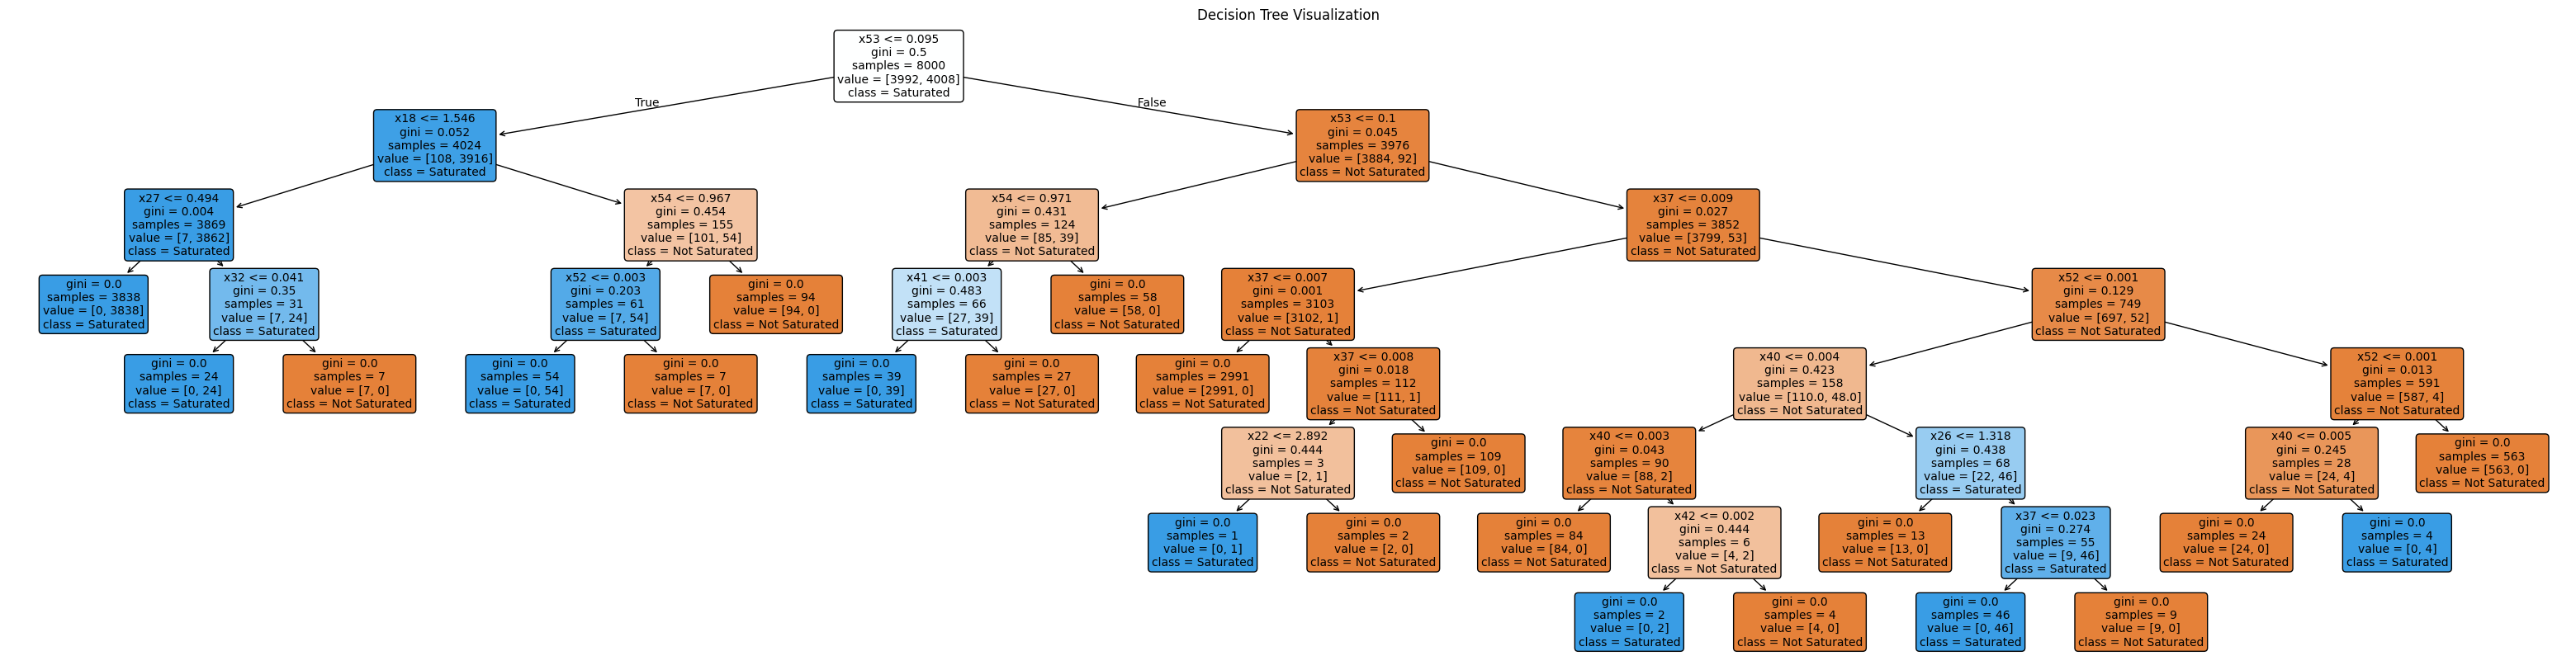

In [12]:

# Plotting the tree
plt.figure(figsize=(40,10))
plot_tree(
    dt_model,
    filled=True,
    rounded=True,
    class_names=['Not Saturated', 'Saturated'],
    feature_names=[f"x{i+1}" for i in range(X_train.shape[1])],
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

The decision tree visualization helps us understand what the model is checking at any point to know how to make a prediction.